In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Reshape, Dropout
from keras.callbacks import LearningRateScheduler

In [2]:
# load the data
train = pd.read_csv(r"\\wsl.localhost\Ubuntu\home\hariprasad\Kannada-MNIST\train.csv")
test = pd.read_csv(r"\\wsl.localhost\Ubuntu\home\hariprasad\Kannada-MNIST\test.csv")

# process data for NN

# Y values are the "label" col in the train.csv file
Y_train = train["label"]

# X values are all the cols except "label"
X_train = train.drop(labels=["label"], axis=1)

# divide each cell value by 255 to get values betn (0, 1)
X_train = X_train / 255.0

# X values are all the cols except "id"
X_test = test.drop(labels=["id"], axis=1)
X_test = X_test / 255.0

In [3]:
print("X_train shape =", X_train.shape)
print("Y_train shape =", Y_train.shape)
print("X_test shape =", X_test.shape)

X_train shape = (60000, 784)
Y_train shape = (60000,)
X_test shape = (5000, 784)


In [4]:
# reshape data to be (28, 28, 1)
X_train = X_train.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)

# one-hot encode Y_train
Y_train = to_categorical(Y_train, num_classes=10)

In [5]:
print("X_train shape =", X_train.shape)
print("Y_train shape =", Y_train.shape)
print("X_test shape =", X_test.shape)

X_train shape = (60000, 28, 28, 1)
Y_train shape = (60000, 10)
X_test shape = (5000, 28, 28, 1)


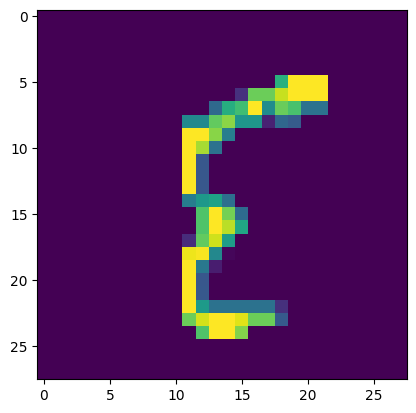

In [6]:
plt.imshow(X_train[9])

In [7]:
# global variables

# LearningRateScheduler(schedule, verbose)
# schedule - a function that takes an epoch index (integer, indexed from 0) 
#            and current learning rate (float) as inputs 
#            and returns a new learning rate as output (float)
# verbose  - 0: quiet, 1: log update messages

annealer = LearningRateScheduler(lambda x: 1e-3 *  0.95 ** x, verbose=0)

#### I will use the following notations to describe the CNN architecture:
- **32C5** = 1 convolution layer with 32 feature maps using a 5x5 filter and stride 1  
- **P2** = max pooling using 2x2 filter and stride 2                                
- **128** = fully connected dense layer with 128 units

784 - [32C5-P2] - [64C5-P2] - 128 - 10 with 40% dropout

In [8]:
# build CNN
input_shape = (28, 28, 1)

model = Sequential()
# 784
model.add(Input(input_shape))
# [32C5-P2]
model.add(Conv2D(32,kernel_size=5,activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.4))
# [64C5-P2]
model.add(Conv2D(64,kernel_size=5,activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.4))
# 128
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
# 10
model.add(Dense(10, activation='softmax'))
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [9]:
# create train and validation (dev) sets from X_train

X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train, Y_train, test_size=0.2)

In [10]:
print("X_train2 shape =", X_train2.shape)
print("Y_train2 shape =", Y_train2.shape)
print("X_val2 shape =", X_val2.shape)
print("Y_val2 shape =", Y_val2.shape)

X_train2 shape = (48000, 28, 28, 1)
Y_train2 shape = (48000, 10)
X_val2 shape = (12000, 28, 28, 1)
Y_val2 shape = (12000, 10)


In [11]:
epochs = 35

history = model.fit(
    X_train2, Y_train2, 
    batch_size=64, 
    epochs = epochs,  
    validation_data = (X_val2,Y_val2), 
    callbacks=[annealer], 
    verbose=0
)

In [12]:
print(
    "Epochs={0:d}, Train accuracy={1:.5f}, Validation accuracy={2:.5f}".format(epochs, max(history.history['accuracy']), max(history.history['val_accuracy']))
)

Epochs=35, Train accuracy=0.99760, Validation accuracy=0.99650


### Validation Accuracy = 99.650%

In [16]:
# save our model

# configuration only saving (serialisation)
model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)


In [17]:
# save our model
import h5py
model.save("model.h5")